In [2]:
import numpy as np
from fashion_mnist.utils import mnist_reader
import matplotlib.pyplot as plt
import pickle

In [3]:
X_train, y_train = mnist_reader.load_mnist('fashion_mnist/data/fashion', kind='train')
X_test, y_test = mnist_reader.load_mnist('fashion_mnist/data/fashion', kind='t10k')

In [4]:
labelDct = {0:"top", 1:"trousers", 2: "pullover", 3:"dress", 4: "coat", 5: "sandal", 6:"shirt", 7:"sneaker",8:"bag",9:"boot"}

dim = len(X_train[0])

In [59]:
def trainPerceptron(X_train, y_train, classList, steps = 30):
    
    dim = len(X_train[0])
    
    mList = [len(classList)*3000]*20
    oldMean = np.mean(mList)
    oldoldMean = np.mean(mList)
    
    mMin = len(classList)*3000

    notLinearlySeparated = True

    aIndices = []
    bIndices = []

    for index, value in enumerate(y_train):
        if value == classList[0]:
            aIndices.append([index,-1])
        elif value == classList[1]:
            bIndices.append([index,1])

    trainingIndices = aIndices + bIndices

    w = np.zeros(dim + 1)
    w = np.random.normal(0, 10, dim+1)

    iterations = 0
    while notLinearlySeparated:
        m = 0
        for pair in trainingIndices:

            index = pair[0]
            y = pair[1]
            x = np.append(X_train[index],1)

            if y * np.dot(w,x) <= 0:
                w += y*x
                m += 1

        iterations += 1
        
        mList.pop(0)
        mList.append(m)
        
        if m <= mMin:
            wBest = w

        if m == 0:
            notLinearlySeparated = False
            print("Separated training data in {} iterations!".format(iterations))
        elif iterations > steps:
            print("Failed to separate data over {} iterations!".format(iterations))
            notLinearlySeparated = False
        
        if (iterations % 15 == 0):
            newMean = np.mean(mList)
            
            if newMean > 1.1 * oldMean and newMean > 1.1 * oldoldMean:
                print("Failed to separate data over {} iterations, m not converging".format(iterations))
                print("Old old mean: {}, Old mean: {}, new mean: {}".
                      format(round(oldoldMean,3),round(oldMean,3), round(newMean,3)))
                notLinearlySeparated = False
            else:
                oldoldMean = oldMean
                oldMean = newMean

    return wBest, notLinearlySeparated

def testPerceptron(w, X_test, y_test, classPair):
    
    aTestIndices = []
    bTestIndices = []

    for index, value in enumerate(y_test):
        if value == classPair[0]:
            aTestIndices.append([index,-1])
        elif value == classPair[1]:
            bTestIndices.append([index,1])

    testIndices =  aTestIndices + bTestIndices

    correct = 0
    incorrect = 0

    correctIndices = []
    incorrectIndices = []

    for pair in testIndices:

        index = pair[0]
        y = pair[1]
        x = np.append(X_test[index],1)

        if y*np.dot(w,x) > 0:
            correctIndices.append(index)
            correct += 1
        else:
            incorrectIndices.append(index)
            incorrect += 1

    percScore = correct/(correct+incorrect)
    return percScore, correctIndices, incorrectIndices

def evalClassPair(classList, steps=30, X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test):
    
    weights, unseparable = trainPerceptron(X_train, y_train, classList, steps = steps)

    score, rightIndices, wrongIndices = testPerceptron(weights, X_train, y_train, classList)
    print("The class list {} scored {}%!".format([labelDct[i] for i in classList],round(score*100,2)))
    return score, rightIndices, wrongIndices, weights


In [8]:
score, rightIndices, wrongIndices, weightDct = evalClassPair([5,7],steps=500)

Failed to separate data over 75 iterations, m not converging
Old old mean: 12.3, Old mean: 12.5, new mean: 14.1
The class list ['sandal', 'sneaker'] scored 72.21%!


In [60]:
def getIndices(classPair, y_train):
    indexDct = {}
    for classifier in classPair:
        
        indexDct.update({classifier:[]})

    for index, value in enumerate(y_train):
        if value in classPair:
            
            indexDct[value].append(index)
    return indexDct


In [61]:
class adaModel:

    def __init__(self, weights, alpha):
         self.weights = weights
         self.alpha = alpha
         

In [62]:
def adaBoost(classPair, steps, y_train):

    indexDct = getIndices(classPair, y_train)
    indices = indexDct[classPair[0]] + indexDct[classPair[1]]
    w = {i:1/len(indices) for i in indices}

    ensemble = []
    alphas = []

    for i in range(steps):
        score, rightIndices, wrongIndices, weights = evalClassPair(classPair, steps=30)
        
        epsilon = sum([w[index] for index in wrongIndices])

        if epsilon >= 0.5:
            weights *= -1
            score, rightIndices, wrongIndices = testPerceptron(weights, X_train, y_train, classPair)
            epsilon = sum([w[index] for index in wrongIndices])

        alpha = 0.5 * np.log((1-epsilon)/epsilon)

        print(alpha)
        for index in rightIndices:
            w[index] *= np.exp(-alpha)/(2*np.sqrt(epsilon*(1-epsilon)))
        
        for index in wrongIndices:
            w[index] *= np.exp(+alpha)/(2*np.sqrt(epsilon*(1-epsilon)))
            
        ensemble.append(adaModel(weights, alpha))
        alphas.append(alpha)
    
    return ensemble, alphas

In [63]:
ensemble, alphas = adaBoost([5,7], steps = 120, y_train= y_train)

Failed to separate data over 31 iterations!
The class list ['sandal', 'sneaker'] scored 56.7%!
0.1348107878626943
Failed to separate data over 31 iterations!
The class list ['sandal', 'sneaker'] scored 65.67%!
0.21032214683034556
Failed to separate data over 31 iterations!
The class list ['sandal', 'sneaker'] scored 66.83%!
0.046625184672539795
Failed to separate data over 31 iterations!
The class list ['sandal', 'sneaker'] scored 58.93%!
0.16655214743610497
Failed to separate data over 31 iterations!
The class list ['sandal', 'sneaker'] scored 65.84%!
0.12278068185180996
Failed to separate data over 31 iterations!
The class list ['sandal', 'sneaker'] scored 64.62%!
0.015244676997153553
Failed to separate data over 31 iterations!
The class list ['sandal', 'sneaker'] scored 67.98%!
0.07107858914014538
Failed to separate data over 31 iterations!
The class list ['sandal', 'sneaker'] scored 66.45%!
0.027983088774371456
Failed to separate data over 31 iterations!
The class list ['sandal', '

In [64]:
classPair = [5,7]

trainScores = []
testScores = []

for i in range(len(ensemble)):

    currentEnsemble = ensemble[:i+1]
    
    H = sum([model.weights * model.alpha for model in currentEnsemble])
    trainScore, rightIndices, wrongIndices = testPerceptron(H, X_train, y_train, classPair)
    testScore, rightIndices, wrongIndices = testPerceptron(H, X_test, y_test, classPair)

    trainScores.append(trainScore)
    testScores.append(testScore)

In [67]:
def getEpsilonsFromAlphas(alphas):

    epsilons = []
    for alpha in alphas:
        epsilon = 1/(1+np.exp(2*alpha))
        epsilons.append(epsilon)

    return epsilons

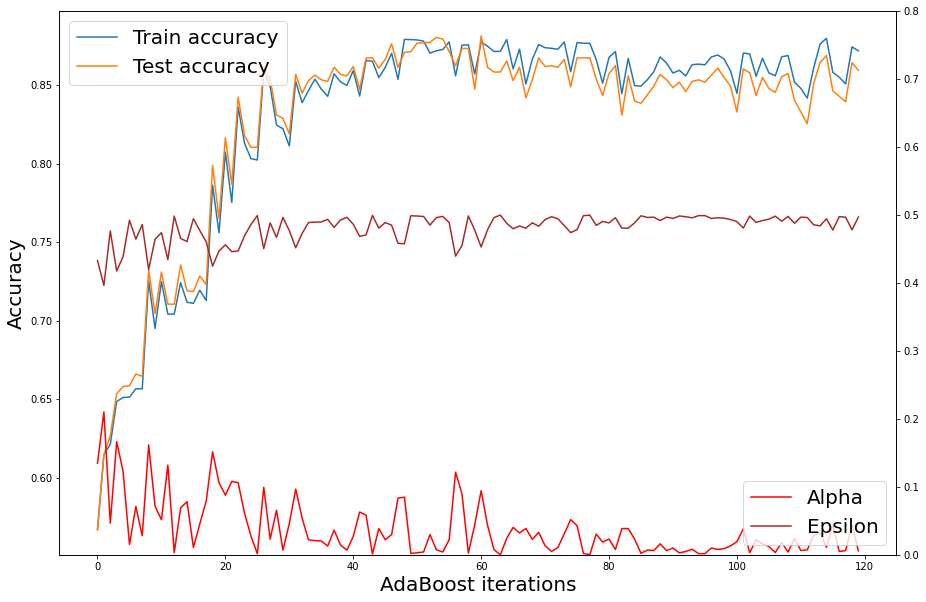

In [73]:
import matplotlib.pyplot as plt

numIterations = len(trainScores)
x = list(range(numIterations))
fig = plt.figure(figsize=(15,10))
ax =fig.add_subplot(111)
ax.plot(x, trainScores, label= "Train accuracy")
ax.plot(x, testScores, label = "Test accuracy")
ax.legend(loc="upper left", fontsize = 20)

ax.set_ylabel("Accuracy", fontsize = 20)
ax.set_xlabel("AdaBoost iterations", fontsize = 20)

ax2 = ax.twinx()
ax2.plot(x, alphas, color="red", label = "Alpha")
ax2.plot(x, getEpsilonsFromAlphas(alphas), color="brown", label="Epsilon")
ax2.legend(loc="lower right", fontsize = 20)
ax2.set_ylim([0,0.8])

plt.show()